In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def fLowFreqRaw(x, a):
    return [1 if x[i]<a else 0 for i in range(len(x))]
#*np.exp(1j*((x/len(x)*2*np.pi)-np.pi))
def fHighFreqRaw(x, a):
    return [0 if x[i]<a else 1 for i in range(len(x))]

def fBandPassFreqRaw(x, a, b):
    return [0 if (x[i]<a)or(x[i]>b) else 1 for i in range(len(x))]

def fBandStopRaw(x, a,b):
    return [1 if (x[i]<a)or(x[i]>b) else 0 for i in range(len(x))]

def freq(x: np.array):
    return np.fft.fftfreq(x.size, d=x[1]-x[0])

def slideringMean(x, N):
    res = np.zeros(len(x))
    addPart = np.zeros(N);
    modified = np.concatenate([addPart,x,addPart])
    for i in range(len(x)):
        shard = np.zeros(2*N)
        for j in range(2*N):
            shard[j] = modified[i+j]
        res[i] = np.mean(shard)
    return res

def softRect(x, a, b, N):
    rect = [0 if (x[i]<a)or(x[i]>b) else 1 for i in range(len(x))]
    return slideringMean(slideringMean(rect,N),N)
    #return slideringMean(rect,N)
    #return rect

def drawSlidering(x, func, N):
    print("частота среза", 1/(x[1]-x[0])/2/N )
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.title("Функция до фильтрации")
    plt.plot(x, func)
    plt.subplot(1,2,2)
    plt.title("Функция после фильтрации")
    plt.plot(x, slideringMean(func, N))
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.title("Спектр функции до фильтрации")
    plt.scatter(w[:len(w)//2], np.real(np.fft.fft(func))[:len(w)//2])
    plt.subplot(1,2,2)
    plt.title("Спектр функции после фильтрации")
    plt.scatter(w[:len(w)//2], np.real(np.fft.fft(slideringMean(func, N)))[:len(w)//2])

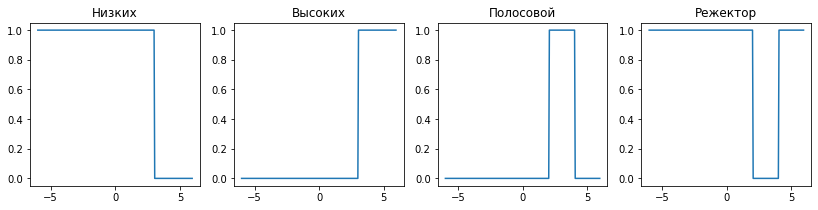

In [3]:
x = np.arange(-6,6,0.05)
w = freq(x)

plt.figure(figsize=(14,3))

plt.subplot(1,4,1)
plt.title("Низких")
plt.plot(x, np.abs(fLowFreqRaw(x, 3)))

plt.subplot(1,4,2)
plt.title("Высоких")
plt.plot(x, np.abs(fHighFreqRaw(x, 3)))

plt.subplot(1,4,3)
plt.title("Полосовой")
plt.plot(x, np.abs(fBandPassFreqRaw(x, 2, 4)))

plt.subplot(1,4,4)
plt.title("Режектор")
plt.plot(x, np.abs(fBandStopRaw(x, 2, 4)))


In [48]:
def lowFilter(x, func, a):
    furier_ideal = np.concatenate([fLowFreqRaw(w,a)[:int(len(w)/2)], np.flip(fLowFreqRaw(w,a)[:int(len(w)/2)])])
    fil = np.fft.ifft(furier_ideal)
    tmp = np.split(fil, 2)
    ideal_filter = np.concatenate([tmp[1], tmp[0]])
    real_filter = ideal_filter*softRect(x,-0.8,0.8,5)
    furier_real_filter = np.fft.fft(real_filter);
    funcAfter = np.convolve(real_filter, func , 'same')
    return funcAfter

def highFilter(x, func, a):
    return func-lowFilter(x,func,a)

def bandPassFilter(x, func, a, b):
    return highFilter(x,lowFilter(x,func,b),a)

def bandStopFilter(x, func, a, b):
    return func-bandPassFilter(x,func,a,b)


def getSpectrum(flt,a):
    graph = np.zeros(len(w))
    tmp = np.zeros_like(w)
    tmp[0]=1
    return np.abs(np.fft.fft(flt(x,tmp,a))) 

def getSpectrum2(flt,a,b):
    graph = np.zeros(len(w))
    tmp = np.zeros_like(w)
    tmp[0]=1
    return np.abs(np.fft.fft(flt(x,tmp,a,b)))  

def drawFiltr(x, funcBefore, funcAfter, spectrum):  
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.title("Функция до фильтрации")
    plt.plot(x, np.real(funcBefore))
    plt.subplot(1,2,2)
    plt.title("Функция после фильтрации")
    plt.plot(x, np.real(funcAfter))
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.title("Спектр функции до фильтрации")
    plt.scatter(w[:len(w)//2], np.abs(np.fft.fft(funcBefore))[:len(w)//2])
    plt.subplot(1,2,2)
    plt.title("Спектр функции после фильтрации")
    plt.scatter(w[:len(w)//2], np.abs(np.fft.fft(funcAfter))[:len(w)//2])

    plt.figure(figsize=(14,4))
    plt.title("Спектр фильтра")
    plt.scatter(w[:len(w)//2],np.abs(spectrum[:len(w)//2])) 

#plt.plot(x, softRect(x,-0.8,0.8,5) )

In [36]:
def testFunc1(x):
    return [10*np.cos(5*x[i])+3*np.cos(15*x[i])+10*np.cos(40*x[i])   for i in range(len(x))]

def testFunc2(x):
    return [np.random.uniform(len(x)-i) for i in range(len(x))]

def testFunc3(x):
    return [np.random.uniform(len(x)) for i in range(len(x))]

def testFunc4(x):
    return [0.5 if (i//20)%2==0 else -0.5 for i in range(len(x))]


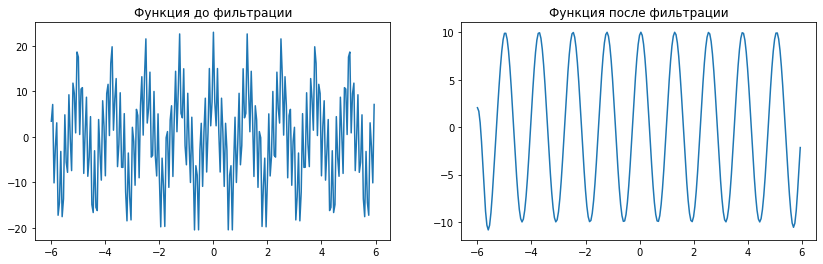

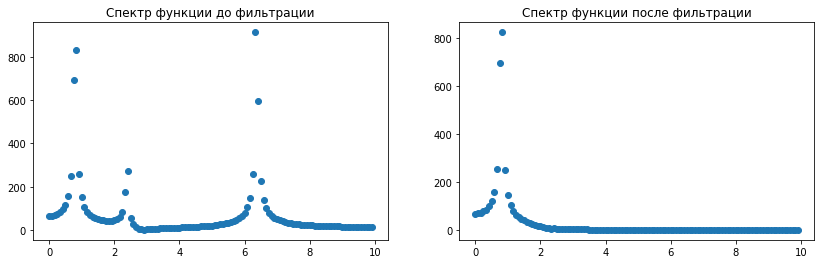

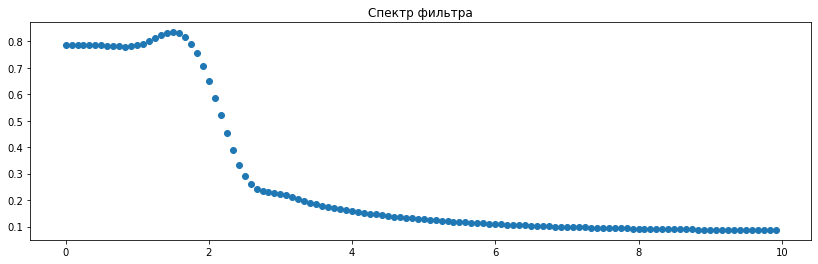

In [37]:
drawFiltr(x, testFunc1(x), lowFilter(x,testFunc1(x),2), getSpectrum(lowFilter,2))

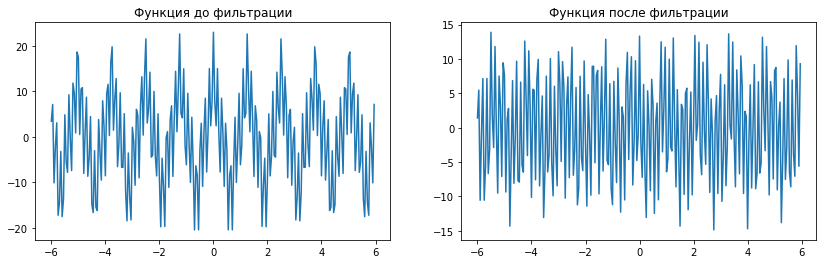

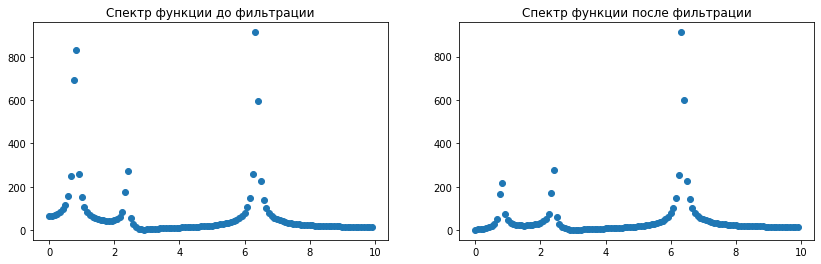

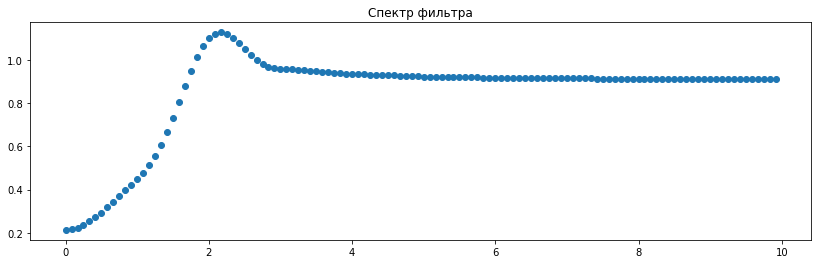

In [38]:
drawFiltr(x, testFunc1(x), highFilter(x,testFunc1(x),2), getSpectrum(highFilter,2))

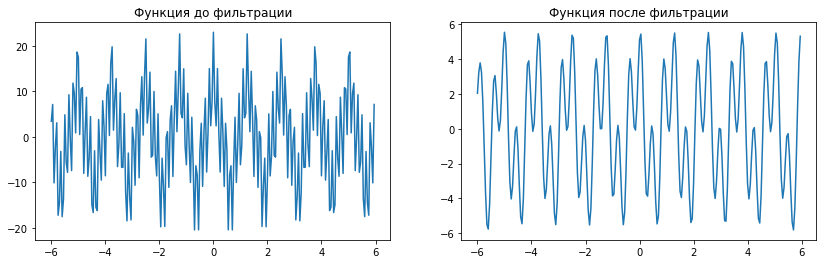

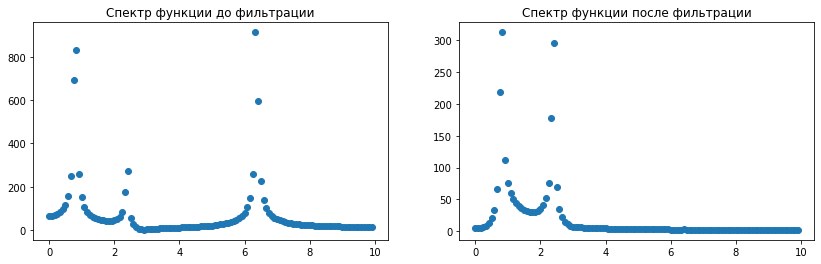

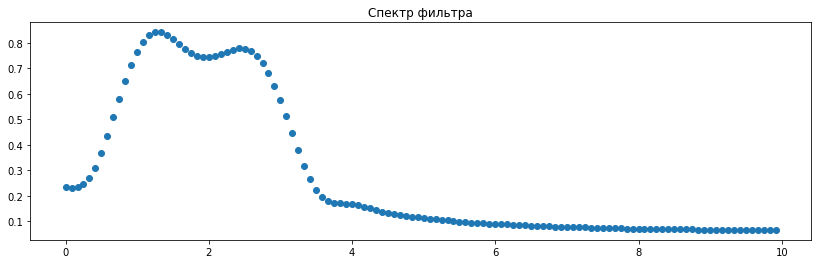

In [43]:
drawFiltr(x, testFunc1(x), bandPassFilter(x,testFunc1(x),1,3), getSpectrum2(bandPassFilter,1,3))

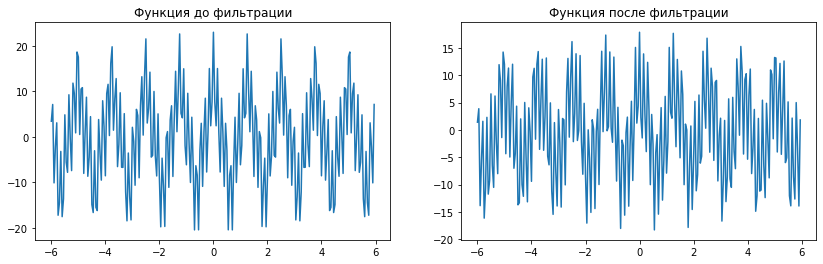

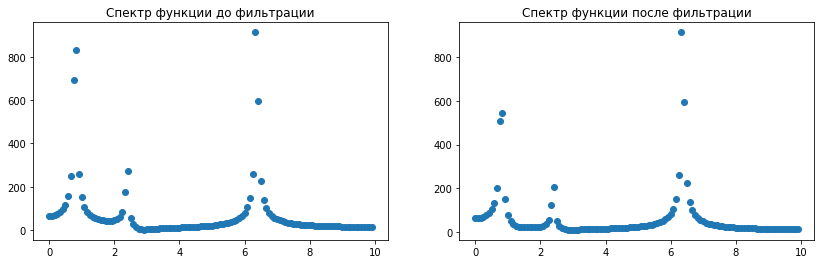

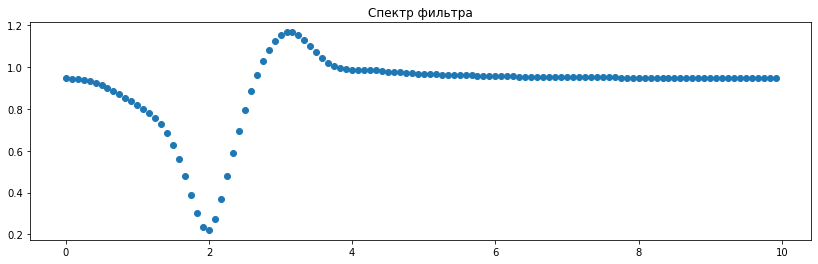

In [50]:
drawFiltr(x, testFunc1(x), bandStopFilter(x,testFunc1(x),1,3), getSpectrum2(bandStopFilter,2,3))